## Estado maximamente emaranhados:

$$
\begin{cases} 
\ket{\Phi^{+}} = \frac{1}{\sqrt{2}} (\ket{00}+{11}) \\
\ket{\Phi^{-}} = \frac{1}{\sqrt{2}} (\ket{00}-{11}) \\
\ket{\Psi^{+}} = \frac{1}{\sqrt{2}} (\ket{01}+{10}) \\
\ket{\Psi^{-}} = \frac{1}{\sqrt{2}} (\ket{01}-{10})
\end{cases} 
$$

## Desigualdade De Bell
- desigualdade de CHSH estabelece um limite máximo para a correlação entre medições locais em dois sistemas separados
- Limite Clássico: $|S|\leq2$
- Limite Quântico: $|S|\leq2\sqrt{2}$

## Desenvolvendo circuitos para Violar a Desigualdade de Bell

1. Preparar estado maximamente emaranhado 
$$
\ket{\Psi^{+}} = \frac{1}{\sqrt{2}} (\ket{01}+{\ket{10}})
$$
2. Realizar medições nos qubits em bases escolhidas para maximizar a violação da desigualdade de Bell
3. Coletar as estatísticas 
4. Calcular a expressão de CHSH com os resultados experimentais.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from qiskit import *
from qiskit.circuit.library import RYGate
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.visualization import plot_histogram


## Mapeamento:
- Criação do circuito com qubtis emaranhados
- Para violar CHSH, as medições devem ser feitas em bases rotacionadas. Logo, vamo aplicar uma porta RY para atingir a violação.
- Utilizamos um função que recebe dois parâmetros: theta_a(Ângulo de medição de Alice) e theta_b(Ângulo de medição de Bob) para criação de um circuito. Esse ângulos contribuiem para determinação das bases para qubit que será medido 


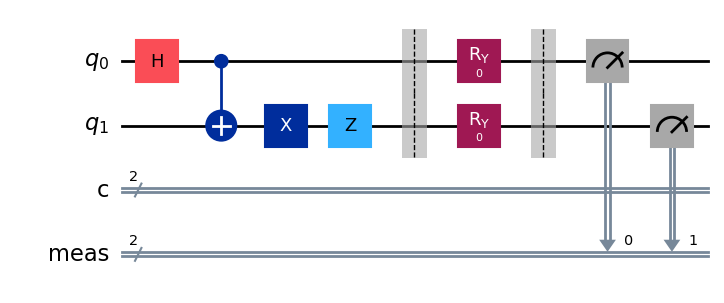

In [4]:
#Função do estado de bell com parametros theta_a e theta_b
def bell_circuit(theta_a, theta_b):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(1)
    qc.z(1)

    qc.barrier()

    #Rotação de um qubit em torno do eixo Y.
    qc.ry(-theta_a, 0) #Rotação de Alice
    qc.ry(-theta_b, 1) #Rotação de Bob
    
    qc.measure_all()
    return qc

# Circuito sem rotação
theta_a = 0
theta_b = 0

circuito = bell_circuit(theta_a, theta_b)
circuito.draw("mpl")

In [5]:
# --- make a copy without the measurements -------------------------
latex = circuito.remove_final_measurements(inplace=False)

# --- get the statevector ------------------------------------------
psi = Statevector.from_instruction(latex)
#print(psi.data)            # raw complex amplitudes

psi.draw(output='latex')          # pretty bra-ket form


<IPython.core.display.Latex object>

## Criação do Backend e Transpilação 
1. Criamos o Backend e 
2. Definimos a quantidade de execuções
3. Criação de um dicionário para armazenar as configurações de medição. E armazenamos os valores dos ângulos para rotação em tuplas theta_a e theta_b
2. Execução de circuitos para ângulos específicos
3. Executar cada circuito para uma das quatro configurações.
4. Loop:
    - Simular quatro experimentos diferentes com quatro ângulos
    - Salva os resultados 

In [6]:
backend= AerSimulator()

# Criação do dicionário com ângulos de rotação 
angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

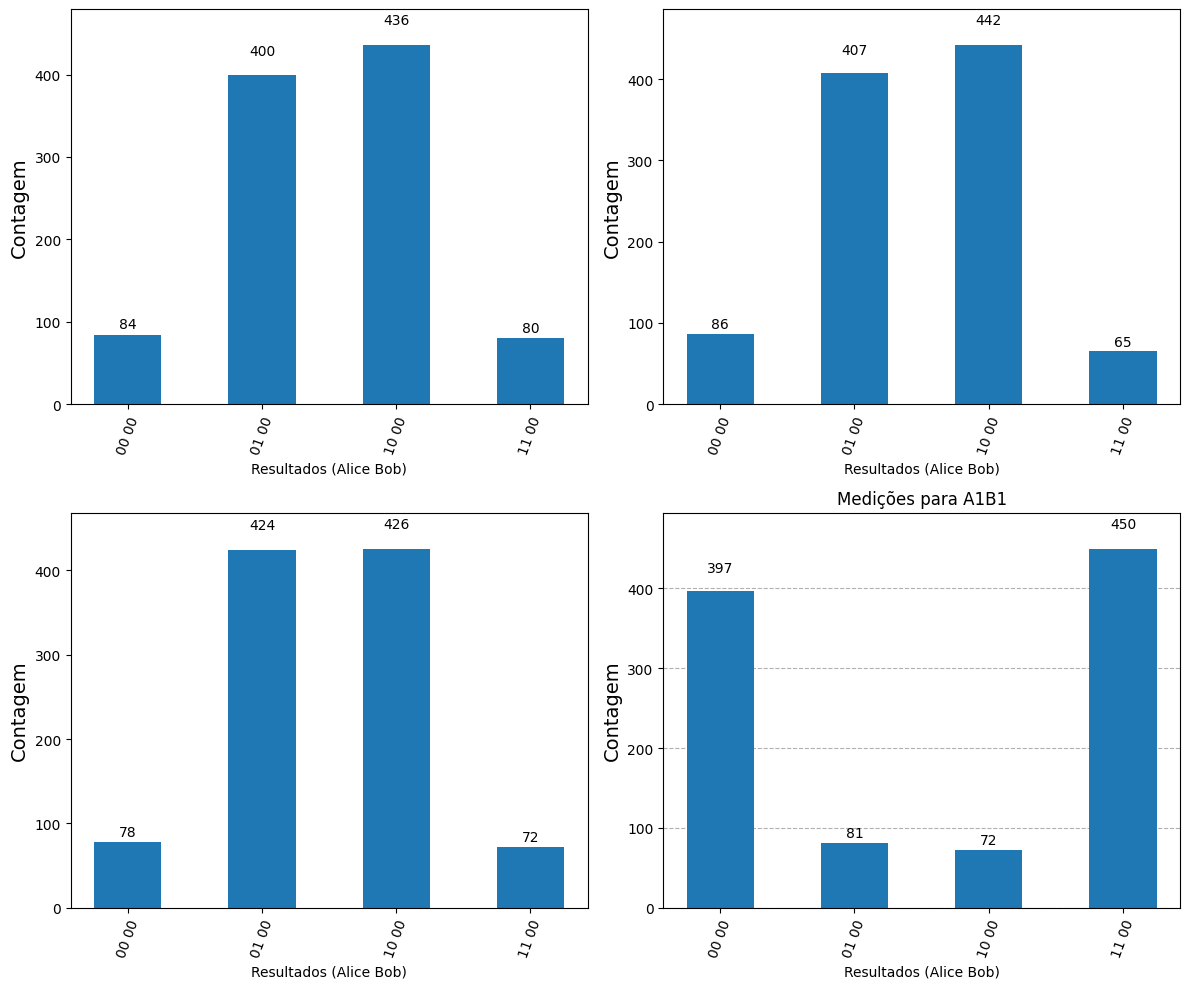

In [7]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Criar uma figura com 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Converter os eixos para uma lista simples para facilitar o loop
axs = axs.ravel()

# Para cada configuração de ângulo, gerar o histograma correspondente
for idx, (label, counts) in enumerate(results_sem_ruido.items()):
    plot_histogram(counts, ax=axs[idx], title=f'Medições para {label}')
    axs[idx].set_xlabel('Resultados (Alice Bob)')
    axs[idx].set_ylabel('Contagem')

plt.tight_layout()
plt.show()


5.  Calcular o valor esperado

$$
E = \sum_{a,b} v(a,b) \cdot P(a,b)
\quad \text{onde} \quad
v(a,b) = 
\begin{cases}
+1 & \text{se } a = b \\
-1 & \text{se } a \neq b
\end{cases}
$$

In [8]:
# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e


## Cálculo do parâmetro CHSH
$$
S =E(A_0,B_0)+E(A_0,B_1)+E(A_1,B_0)-E(E_1,B_1)
$$
- Se 
$∣S∣>2$, há violação da desigualdade clássica, provando não-localidade quântica.

In [9]:
E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S = abs(S)
print(f"S = {S:.3f}")

S = 2.764


## Códigos dos ângulos:

In [10]:
angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S1 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S2 = abs(S)


###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S3 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S4 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S5 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S6 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S7 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S8 = abs(S)

###

angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_sem_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend) #adapta o circuito para o backend (aqui, o simulador).
    job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()
    results_sem_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e

E = {label: expectation(c) for label, c in results_sem_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S9= abs(S)

Valores_S = np.array([[S1,S2,S3],[S4,S5,S6],[S7,S8,S9]])
print(Valores_S)

[[2.86  2.822 2.86 ]
 [2.858 2.896 2.778]
 [2.818 2.746 2.902]]


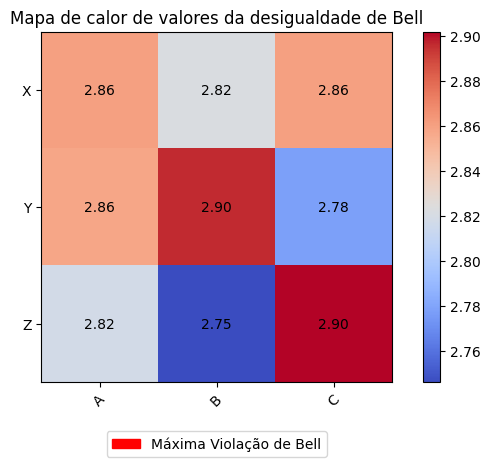

In [11]:
df = pd.DataFrame({
    'A': [Valores_S[0,0],Valores_S[1,0],Valores_S[2,0]],
    'B': [Valores_S[0,1],Valores_S[1,1],Valores_S[2,1]],
    'C': [Valores_S[0,2],Valores_S[1,2],Valores_S[2,2]]
},index = ['X', 'Y', 'Z'])

fig, ax = plt.subplots()
im = ax.imshow(df.values, cmap='coolwarm')

plt.colorbar(im)

ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.index)))
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.index)

plt.xticks(rotation=45)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        valor = f"{df.iloc[i, j]:.2f}"
        cor = "white" if df.iloc[i, j] < 0.5 else "black"
        ax.text(j, i, valor, ha="center", va="center", color=cor)


Max_violacao = mpatches.Patch(color='red', label='Máxima Violação de Bell')
legenda = plt.legend(handles=[Max_violacao], loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1)
plt.title("Mapa de calor de valores da desigualdade de Bell")
plt.tight_layout()
plt.show()

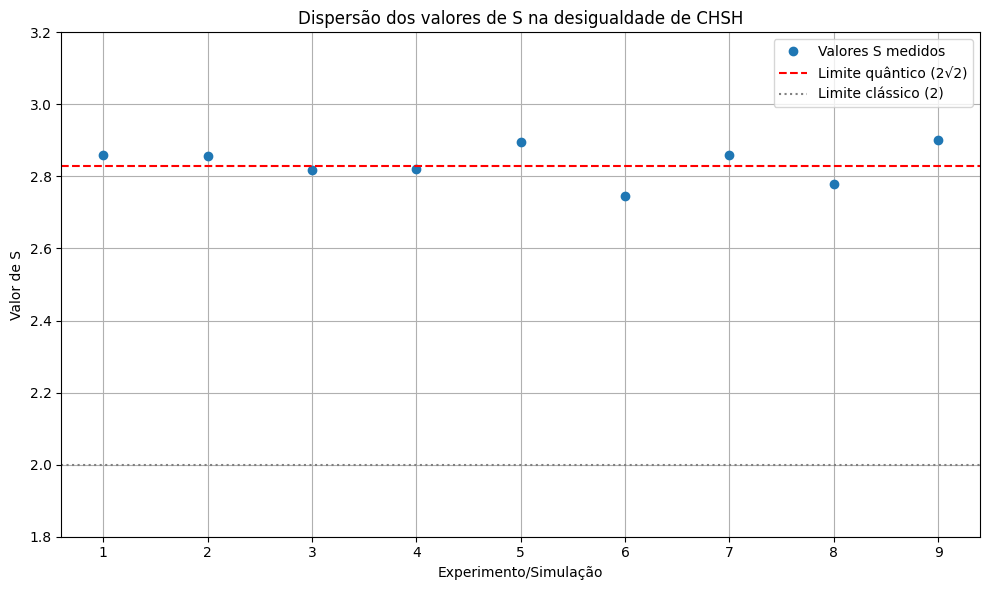

In [15]:
valores_S = [Valores_S[0,0],Valores_S[1,0],Valores_S[2,0],Valores_S[0,1],Valores_S[1,1],Valores_S[2,1],Valores_S[0,2],Valores_S[1,2],Valores_S[2,2]]
indices = list(range(1, len(valores_S)+1))

plt.figure(figsize=(10, 6))
plt.plot(indices, valores_S, marker='o', linestyle='', label='Valores S medidos')

plt.axhline(y=2*np.sqrt(2), color='red', linestyle='--', label='Limite quântico (2√2)')

plt.axhline(y=2, color='gray', linestyle=':', label='Limite clássico (2)')

plt.title('Dispersão dos valores de S na desigualdade de CHSH')
plt.xlabel('Experimento/Simulação')
plt.ylabel('Valor de S')
plt.ylim(1.8, 3.2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
